In [1]:
import pandas as pd
from datasets import load_dataset
import os

/opt/conda/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Our data begins as a bunch of PGN transcripts. However, to work in tensors we need all transcripts to be the same length. So, this file takes our PGNs and performs some filtering.

This notebook has a very similar counterpart, `utils\chess_gpt_eval_data_filtering.ipynb`. The lichess and chess_gpt_eval datasets have a different structure and different column names. For most peoples' needs, the lichess dataset alone should suffice, so I made two separate notebooks to keep this one simple.

The output of this file is 4 different csv's:

`lichess_100mb.csv`" 100 MB of lichess PGN games, with every game also containing player Elo information.

`lichess_100mb_filtered.csv`: We perform some filtering for game length, add player Elo bucket, and do some manipulation of the PGN string.

`lichess_train.csv` and `lichess_test.csv` a 50 / 50 train / test split of `lichess_100mb_filtered.csv`, used for training and testing linear probes.

In [2]:
DATA_DIR = "data/"
prefix = "lichess_"


input_file = f'{DATA_DIR}{prefix}100mb.csv'
output_file = input_file.replace(".csv", "_filtered.csv")

First, we download the dataset if not present.

In [3]:
if not os.path.exists(input_file):
    dataset_path = "adamkarvonen/chess_games"
    file_path = f"{prefix}100mb.zip"
    # No idea why streaming=True is required to avoid an error here. Huggingface ¯\_(ツ)_/¯
    dataset = load_dataset(dataset_path, data_files=file_path,streaming=True)
    df = pd.DataFrame(dataset['train'])
    df.to_csv(input_file, index=False)

Repo card metadata block was not found. Setting CardData to empty.


Our LLMs need a delimiter token ";" at the beginning of every PGN string or it won't work as well.

In [4]:
df = pd.read_csv(input_file)

def format_transcript(game: str) -> str:
    new_game = ';' + game
    return new_game

df['transcript'] = df['transcript'].apply(format_transcript)

for game in df.head()['transcript']:
    print(game)
    print()

;1.d4 e6 2.c4 Nf6 3.Nc3 Bb4 4.Bg5 h6 5.Bxf6 Qxf6 6.Nf3 O-O 7.e4 Bxc3+ 8.bxc3 d6 9.Bd3 e5 10.h3 c5 11.d5 b6 12.Nh2 Qe7 13.O-O Nd7 14.f4 exf4 15.Rxf4 Ne5 16.Bf1 Ba6 17.Ng4 f6 18.Qe1 Bc8 19.Qg3 Bxg4 20.hxg4 Rf7 21.Be2 Qd7 22.Raf1 Qa4 23.g5 hxg5 24.Rf5 Qxa2 25.Bh5 Rff8 26.Qh3 Qxc4 27.Rxe5 fxe5 28.Qe6+ Kh8 29.Bf7 Qd3 30.Rf3 Qxf3 31.gxf3 g6 32.Qf6+ Kh7 33.Qxg6+ Kh8 34.Qh6#

;1.e4 e5 2.Nf3 f6 3.d4 a5 4.dxe5 fxe5 5.Bc4 Nc6 6.Nc3 a4 7.Ng5 Na5 8.Qh5+ g6 9.Bf7+ Ke7 10.Nd5+ Kd6 11.b3 gxh5 12.Ba3+ Kc6 13.Nb4+ Kc5 14.O-O-O Kb5 15.Rd5+ Kb6 16.c4 Qxg5+ 17.Kb1 Qxg2 18.Rb5+ Ka7 19.Rb6 cxb6 20.Rc1 Qxe4+ 21.Ka1 Qd4+

;1.d4 Nf6 2.Nf3 e6 3.Nbd2 d5 4.e3 Be7 5.Bd3 O-O 6.O-O h6 7.c3 b6 8.e4 Bb7 9.e5 Nfd7 10.Re1 c5 11.Nf1 c4 12.Bc2 f6 13.Ng3 fxe5 14.Nxe5 Nxe5 15.Rxe5 Qd6 16.Qg4 Kh8 17.Nh5 Rf7 18.Qg6 Kg8 19.Bxh6 Nd7 20.Qh7+ Kf8 21.Qh8#

;1.e4 e5 2.Nf3 Nc6 3.Bb5 f5 4.d3 Nf6 5.O-O d6 6.Bg5 Be7 7.Nc3 O-O 8.Bxf6 Bxf6 9.Nd5 Ne7 10.Bc4 Kh8 11.Nxe7 Qxe7 12.Re1 fxe4 13.dxe4 Bd7 14.h3 Bg5 15.Nxg5 Qxg5 16.Re3 Rf4 17.Rg3 Q

/tmp/ipykernel_413982/1812804111.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file)


Filter all games to be len 365. This means we discard anything under that length. I chose 365 because that's the 50% of df.describe(). I also count the number of moves (with x.split()) and discard anything below the 25th percentile. This makes it easier if I want to do any move based indexing.

In [5]:
len_df = df['transcript'].apply(lambda x: len(x))
print(len_df.describe())

game_length_in_chars = 365

# Data setup. All games must have same length. 50% are >= 690 moves. I will discard all games less than 680, and truncate the rest to 680.
filtered_df = df[df['transcript'].apply(lambda x: len(x) >= game_length_in_chars)].copy()
filtered_df.loc[:, 'transcript'] = filtered_df['transcript'].apply(lambda x: x[:game_length_in_chars])

len_df = filtered_df['transcript'].apply(lambda x: len(x))
print(len_df.describe())

move_count_df = filtered_df['transcript'].apply(lambda x: len(x.split()))
move_count = move_count_df.describe()
print("move count", move_count_df.describe())
quarter_percentile = move_count['25%']
print("quarter percentile", quarter_percentile)

# Now I need to filter out games that are too short. I will discard all games less than 25th percentile  moves.
filtered_df = filtered_df[filtered_df['transcript'].apply(lambda x: len(x.split()) >= quarter_percentile)]
print(filtered_df.describe())
print(filtered_df.head())

filtered_df.to_csv(output_file, index=False)

move_count_df = filtered_df['transcript'].apply(lambda x: len(x.split()))
print(move_count_df.describe())

count    291345.000000
mean        390.737998
std         158.994060
min         137.000000
25%         273.000000
50%         364.000000
75%         483.000000
max        2077.000000
Name: transcript, dtype: float64
count    145249.0
mean        365.0
std           0.0
min         365.0
25%         365.0
50%         365.0
75%         365.0
max         365.0
Name: transcript, dtype: float64
move count count    145249.000000
mean         66.580899
std           1.187799
min          62.000000
25%          66.000000
50%          67.000000
75%          67.000000
max          72.000000
Name: transcript, dtype: float64
quarter percentile 66.0
            WhiteElo
count  116159.000000
mean     1772.945557
std       264.868858
min       797.000000
25%      1596.000000
50%      1768.000000
75%      1945.000000
max      2874.000000
    WhiteElo BlackElo Result  \
0       2339     2080    1-0   
7       1739     1727    1-0   
8       1724     1661    0-1   
9       1903     1900    1-0   
10   

In [6]:
print(len(filtered_df))
print(filtered_df['WhiteElo'].describe())

116159
count    116159.000000
mean       1772.945557
std         264.868858
min         797.000000
25%        1596.000000
50%        1768.000000
75%        1945.000000
max        2874.000000
Name: WhiteElo, dtype: float64


For the classification task, I wanted some Elo bins for the probe to classify. This somewhat arbitrarily creates 6 different Elo bins.

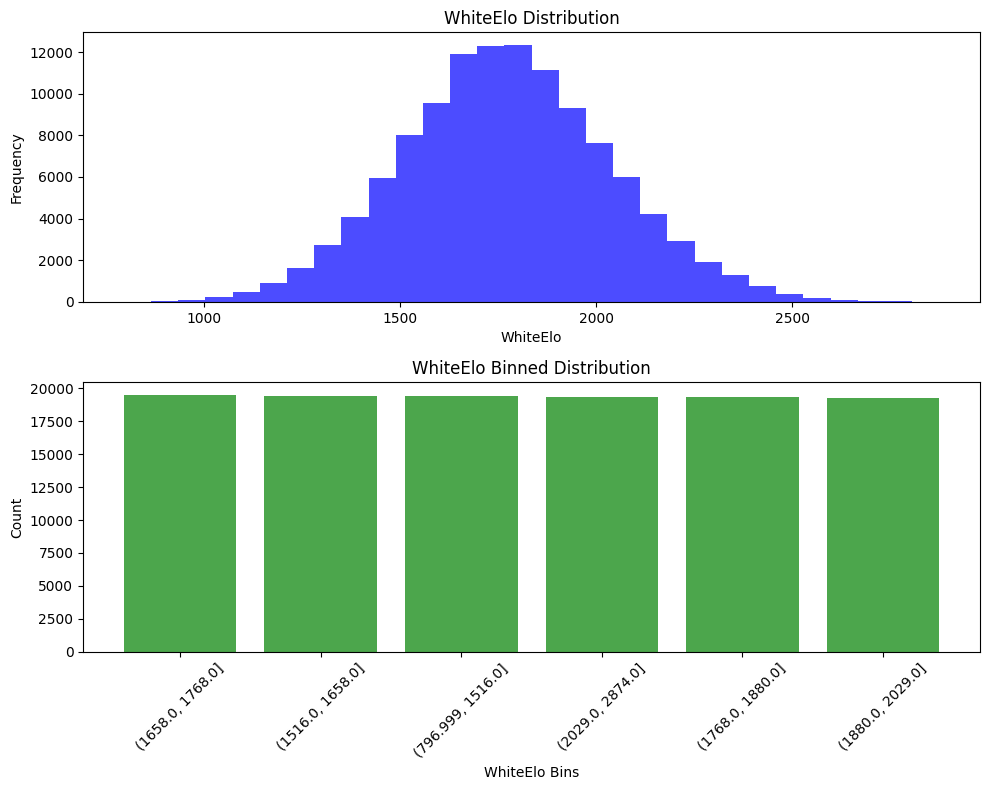

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# Function to create binned columns and bin index columns
def create_binned_columns(df, column_name):

    # Ensure column is numeric and handle NaN values. Here, we choose to drop them, but you might fill them instead.
    if df[column_name].dtype.kind not in 'biufc' or pd.isnull(df[column_name]).any():
        df = df.dropna(subset=[column_name])
        df[column_name] = pd.to_numeric(df[column_name], errors='coerce')

    binned_column_name = f'{column_name}Binned'
    bin_index_column_name = f'{column_name}BinIndex'
    
    # Create quantile-based bins
    num_bins = 6
    # Create quantile-based bins with range labels, dropping duplicates if necessary
    df[binned_column_name], bins = pd.qcut(df[column_name], q=num_bins, retbins=True, duplicates='drop')

    # Convert bin labels to strings and assign to the column
    df[binned_column_name] = df[binned_column_name].apply(lambda x: f'({x.left}, {x.right}]')

    # Create bin index column
    df[bin_index_column_name] = pd.qcut(df[column_name], q=num_bins, labels=False, duplicates='drop')

# Apply the function to both WhiteElo and BlackElo
create_binned_columns(filtered_df, 'WhiteElo')
create_binned_columns(filtered_df, 'BlackElo')

filtered_df.to_csv(output_file, index=False)

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Histogram for WhiteElo
axes[0].hist(filtered_df['WhiteElo'], bins=30, color='blue', alpha=0.7)
axes[0].set_title('WhiteElo Distribution')
axes[0].set_xlabel('WhiteElo')
axes[0].set_ylabel('Frequency')

# Bar chart for WhiteEloBinned
bin_counts = filtered_df['WhiteEloBinned'].value_counts()
axes[1].bar(bin_counts.index.astype(str), bin_counts.values, color='green', alpha=0.7)
axes[1].set_title('WhiteElo Binned Distribution')
axes[1].set_xlabel('WhiteElo Bins')
axes[1].set_ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



In [8]:
print(filtered_df['WhiteEloBinned'].value_counts())

WhiteEloBinned
(1658.0, 1768.0]     19458
(1516.0, 1658.0]     19402
(796.999, 1516.0]    19385
(2029.0, 2874.0]     19350
(1768.0, 1880.0]     19336
(1880.0, 2029.0]     19228
Name: count, dtype: int64


In [9]:
print(filtered_df.head())

    WhiteElo BlackElo Result  \
0       2339     2080    1-0   
7       1739     1727    1-0   
8       1724     1661    0-1   
9       1903     1900    1-0   
10      1916     1901    1-0   

                                           transcript    WhiteEloBinned  \
0   ;1.d4 e6 2.c4 Nf6 3.Nc3 Bb4 4.Bg5 h6 5.Bxf6 Qx...  (2029.0, 2874.0]   
7   ;1.c4 e6 2.Nc3 c5 3.e3 Nf6 4.Nf3 Be7 5.Be2 O-O...  (1658.0, 1768.0]   
8   ;1.e4 d5 2.exd5 Qxd5 3.Nc3 Qd8 4.Nf3 Nf6 5.Bc4...  (1658.0, 1768.0]   
9   ;1.e4 c5 2.Nf3 d6 3.c3 Nf6 4.Bd3 Nc6 5.Bc2 e5 ...  (1880.0, 2029.0]   
10  ;1.e4 e5 2.Nf3 d5 3.d4 Bd6 4.dxe5 dxe4 5.exd6 ...  (1880.0, 2029.0]   

    WhiteEloBinIndex  
0                  5  
7                  2  
8                  2  
9                  4  
10                 4  


In [10]:
# shuffle all rows of the dataset

df = pd.read_csv(output_file)
df = df.sample(frac=1, random_state=200).reset_index(drop=True)
df.to_csv(output_file, index=False)

In [11]:
import pandas as pd
df = pd.read_csv(output_file)

print(len(df))

# Split df into a train and test split
train = df.sample(frac=0.5, random_state=200)
test = df.drop(train.index)

print(len(train))
print(len(test))

# Save the train and test splits to csv
train.to_csv(f'{DATA_DIR}{prefix}train.csv', index=False)
test.to_csv(f'{DATA_DIR}{prefix}test.csv', index=False)

116159
58080
58079
